In [1]:
import os
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121
from keras import backend as K
from keras.optimizers import SGD, Adagrad, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Reshape, Activation, Multiply,GlobalMaxPooling2D
from keras.layers import LSTM, TimeDistributed, Dropout, Input, Flatten, Lambda, Concatenate, Average, Permute
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.layers import concatenate
from keras.regularizers import l1, l2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
def get_model_densenet121(num_classes,weights='imagenet'):
    # create the base pre-trained model
    base_model = DenseNet121(weights=weights, include_top=False)
    x = base_model.output
    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

## Show Available Model

In [3]:
num_classes = 196
folder = 'saved_models' #Change this according to your saved model path
moddir = os.listdir(folder)
print(moddir)

['model_all_finetuned.029-0.48-0.89.hdf5', 'model_all_finetuned.040-0.56-0.88.hdf5']


In [4]:
used_model = moddir[0]


model = get_model_densenet121(num_classes) #Densenet121
model.load_weights(os.path.join(folder,used_model))

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
test_data_dir = 'data/test' #Change this to your data path
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_gen = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

Found 8041 images belonging to 196 classes.


## Evaluate Data with Test Generator

Highest test data accuracy we achieved was 0.78^

In [6]:
model.evaluate_generator(test_gen, steps=503)

[1.2058259496291766, 0.7671931351970165]

In [7]:
test_gen.reset() #to avoid having bugs in generator.

## Confusion Matrix

In [8]:
import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
from console_progressbar import ProgressBar
from sklearn.metrics import classification_report
pred = model.predict_generator(test_gen, steps=503, verbose=1)
test_gen.reset() #to avoid having bugs in generator.
predicted = np.argmax(pred, axis=1)

cars_meta = scipy.io.loadmat('devkit/cars_meta') #Change this to your cars_meta path
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)
print('class_names.shape: ' + str(class_names.shape))
print('Sample class_name: [{}]'.format(class_names[8][0][0]))
import re
new_classnames = []
regexp = re.compile('/')
for i in range(class_names.shape[0]):
    if regexp.search(class_names[i][0][0]):
        cl_temp = re.sub('/','-',class_names[i][0][0])
        print("Changed",class_names[i][0][0],"to",cl_temp)
        new_classnames.append(cl_temp)
    else:
        new_classnames.append(class_names[i][0][0])
print('Classification Report')
print(classification_report(test_gen.classes, predicted, target_names=new_classnames))

503/503 [==============================] - 30s 61ms/step
class_names.shape: (196, 1)
Sample class_name: [Aston Martin V8 Vantage Coupe 2012]
Changed Ram C/V Cargo Van Minivan 2012 to Ram C-V Cargo Van Minivan 2012
Classification Report
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.58      0.93      0.71        44
                                   Acura RL Sedan 2012       0.61      0.69      0.65        32
                                   Acura TL Sedan 2012       0.63      0.88      0.74        43
                                  Acura TL Type-S 2008       0.94      0.74      0.83        42
                                  Acura TSX Sedan 2012       0.90      0.65      0.75        40
                             Acura Integra Type R 2001       0.79      0.84      0.81        44
                              Acura ZDX Hatchback 2012       0.87      0.69      0.77      

## Plot Prediction

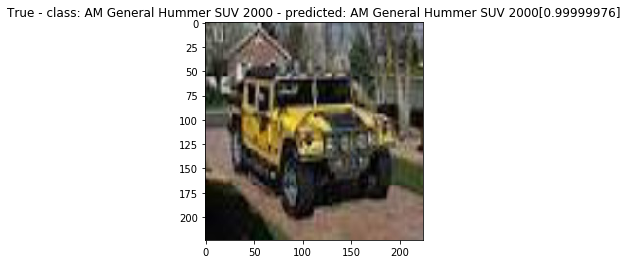

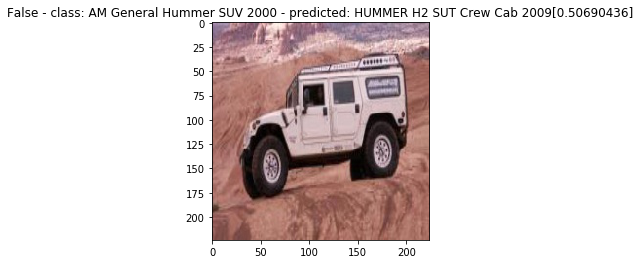

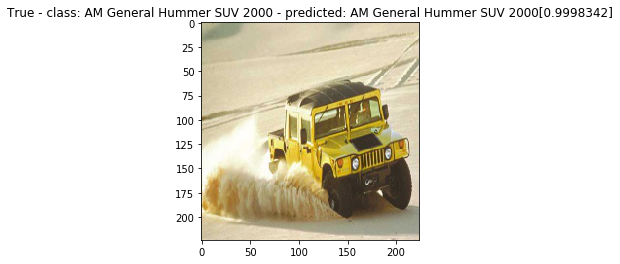

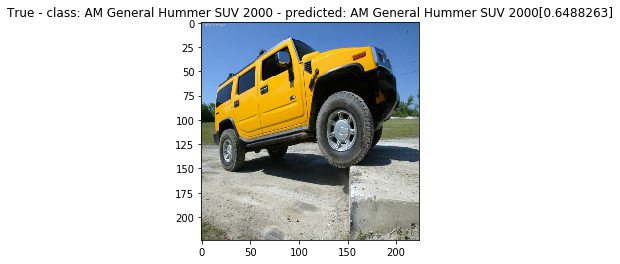

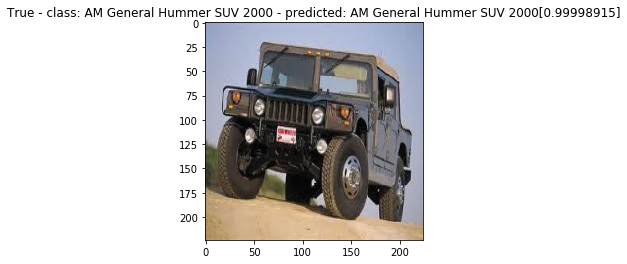

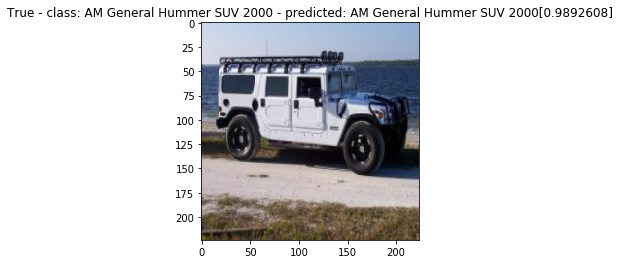

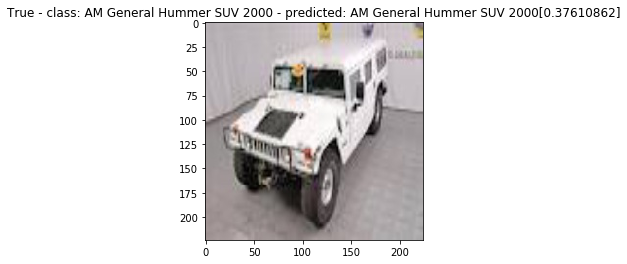

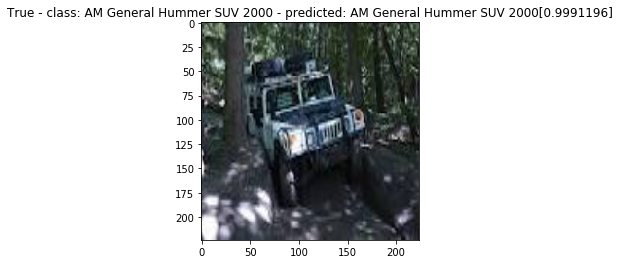

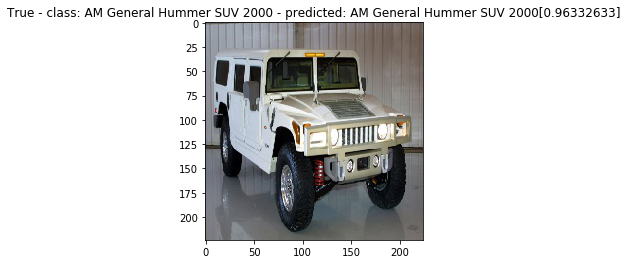

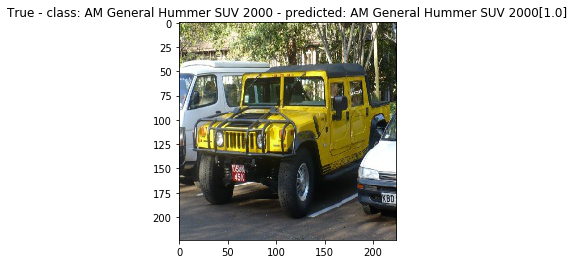

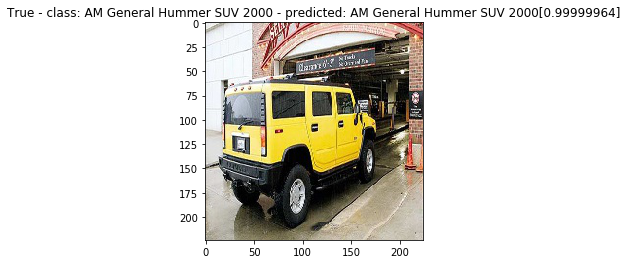

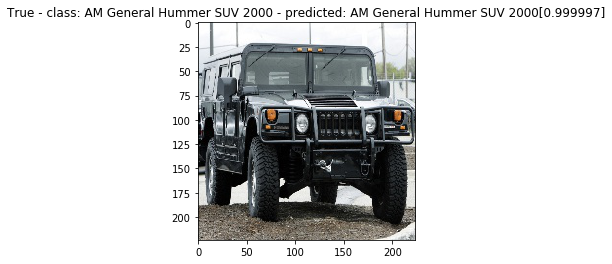

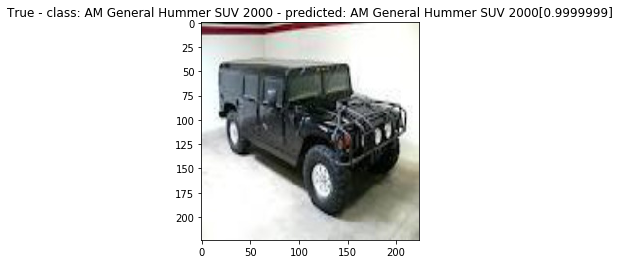

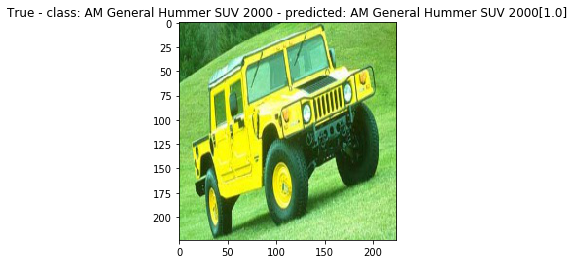

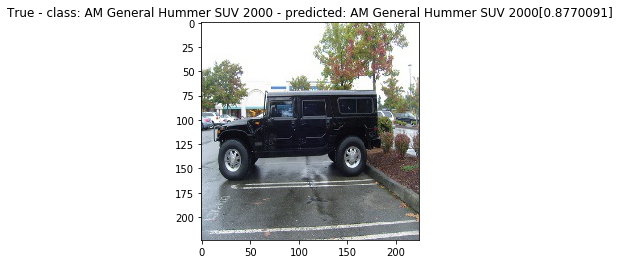

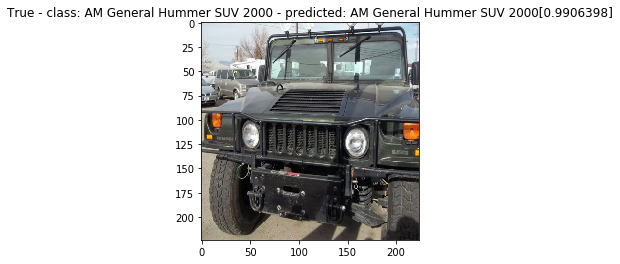

In [9]:
def predict_one(model):
    image_batch, classes_batch = next(test_gen)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0]):
        image = image_batch[k]
        pred = predicted_batch[k]
        the_pred = np.argmax(pred)
        predicted = class_names[the_pred]
        val_pred = max(pred)
        the_class = np.argmax(classes_batch[k])
        value = class_names[np.argmax(classes_batch[k])]
        plt.figure(k)
        isTrue = (the_pred == the_class)
        plt.title(str(isTrue) + ' - class: ' + value[0][0] + ' - ' + 'predicted: ' + predicted[0][0] + '[' + str(val_pred) + ']')
        plt.imshow(image)

predict_one(model)